In [1]:
from syngem_utils import *
from load_models import *

In [2]:
import torch
import pandas as pd
import numpy as np
import pickle as pkl
import argparse
import yaml
import scipy

In [3]:
syn_model = load_synflow_resnet20_1_66_sparsity();
gem_model = load_gemini_resnet20_1_44_sparsity();

=> Reading YAML config from Configs/synflow_fc.yml
=> Reading YAML config from Configs/hypercube/resnet20/resnet20_quantized_iter_hc_target_sparsity_1_4_highreg.yml
==> Conv Type: SubnetConv
==> BN Type: AffineBatchNorm
==> Building first layer


In [4]:
syn_sparsity = check_sparsity(syn_model)
gem_sparsity = check_sparsity(gem_model)

In [5]:
print("syn_model:", syn_sparsity)
print("gem_model:", gem_sparsity)

syn_model: {'overall_sparsity': 1.009}
gem_model: {'overall_sparsity': 1.439}


In [6]:
syn_filters = get_filters(syn_model)
gem_filters = get_filters(gem_model)

# sparsity function for filters
### --> dictionary(layer_1: [1.23 , 3.21 , ... , 4.12], layer_2: [...])

In [13]:
# load random image to create feature map on
test_image = get_images_cifar10(batch_size=4)

Files already downloaded and verified
Files already downloaded and verified


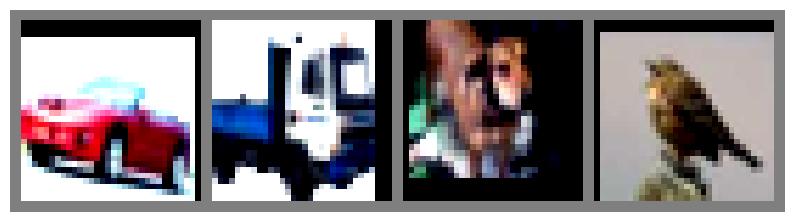

GroundTruth:  car   truck dog   bird 


In [17]:
img, _ = test_image.get_new_images(output=True)
test_image.display((10,10))

# compare NN's from bottom to top
### --> starting from weight matrices magnitude, to weight matrices structure (one - to one, one to many)
### --> to kernel individual feature maps, to filter feature space, 

reasons: matrix weight dont tell anything about the structure, both magnitude and structure combined dont tell us about the correlation of feature map, e.g inverse edge detector has distance 1 (complete opposite) and corelation 1 (both feature maps are positively corelated). 
Next the single feature maps are condensed to one feature map which is the output of the filter and here again the individual feature maps might be not corelated, they final feature map they make up might be corealltead to another filters feature map. 

# look at gradients of feature map ?

In [19]:
# comparing weight matrices magnitudes
# any outliers ?
# uniformly distributed ?
# overall magnitude and direction ?
test_weight_matrix_1 = np.array([[-1,0,1], 
                                 [-2,0,2],
                                 [-1,0,1]])

test_weight_matrix_2 = np.array([[1,0,-1], 
                                 [2,0,-2],
                                 [1,0,-1]])



In [43]:
# from Liu et al.
def getNormalizedEditDistance(a, b):

    # for two hidden neuron trees, return 1 if they are completely different, 0 if they are exactly the same
    if (len(a) == 0 and len(b) == 0):
        return 0
    intersect, inda, indb = np.intersect1d(a, b, return_indices=True)
    if (intersect.shape[0] > 0):
        edit = np.delete(a, inda).shape[0] + np.delete(b, indb).shape[0]
        normalizedEdit = edit / np.unique(np.concatenate((a, b), axis=0)).shape[0]
    else:
        normalizedEdit = 1
    return normalizedEdit

# distance created by Isabel
# gets two vectors with all weights (! and not just the connection indices) and gives back edit distance
def editDistanceSigns(a,b):
    nums = len(a) - len(np.intersect1d(np.where(b==0), np.where(a==0)))
    same = len(np.intersect1d(np.where(a<0), np.where(b<0))) + len(np.intersect1d(np.where(a>0), np.where(b>0)))
    if nums == 0:
        return 0
    return (nums-same)/nums


# MAED 
def mean_absolute_error_distance(a,b):
    
    a_flat_sort = np.sort(a.flatten())
    b_flat_sort = np.flip(np.sort(b.flatten()))
    
    worst_alignment = sum(abs(a_flat_sort - b_flat_sort))

    dist = sum(abs(a - b).flatten()) / worst_alignment
    
    
    return dist

In [44]:
dist_liu = getNormalizedEditDistance(test_weight_matrix_1.flatten(), test_weight_matrix_2.flatten())
dist_isa = editDistanceSigns(test_weight_matrix_1.flatten(), test_weight_matrix_2.flatten())
dist_tja = mean_absolute_error_distance(test_weight_matrix_1, test_weight_matrix_2)

In [45]:
print("dist_liu: ", dist_liu)
print("dist_isa: ", dist_isa)
print("dist_tja: ", dist_tja)

dist_liu:  1.6
dist_isa:  1.0
dist_tja:  1.0


In [42]:
test_weight_matrix_1.mean()

0.0

In [9]:
syn_feat = get_feature_map(img, syn_filters)
gem_feat = get_feature_map(img, gem_filters)

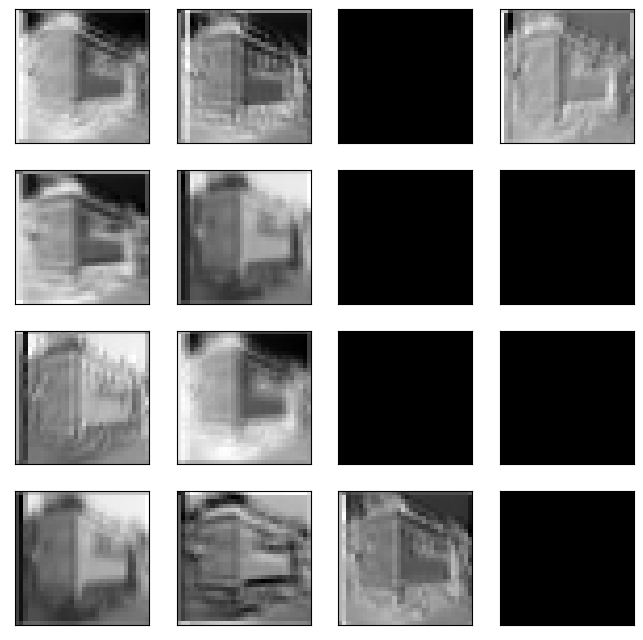

In [47]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8,8))

layer = 0
single_filter = 0

for ax in axs.flat:
    img = syn_feat[layer][single_filter]
    ax.imshow(img, cmap = "gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    single_filter += 1

plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10,10))

layer = 0
single_filter = 0

for ax in axs.flat:
    img = gem_feat[layer][single_filter]
    ax.imshow(img)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    single_filter += 1

plt.show()

In [ ]:
#dist_1 = getNormalizedEditDistance(syn_filters[0][3].flatten(), gem_filters[0][3].flatten())
dist_1 = editDistanceSigns(syn_filters[0][3].flatten(), gem_filters[0][3].flatten())
dist_2 = mean_absolute_error_distance(syn_filters[0][3],gem_filters[0][3])

In [ ]:
print(dist_1 , dist_2)

In [ ]:
for i in range(16):
    for j in range(16):
        dist_1 = editDistanceSigns(syn_filters[0][i].flatten(), gem_filters[0][j].flatten())
        dist_2 = mean_absolute_error_distance(syn_filters[0][i],gem_filters[0][j])
        
        if abs(dist_1 - dist_2) > 0.06:
            print("edit_dist ", i , j , dist_1)
            print("my_dist ", i , j ,   dist_2)
            print("")

In [ ]:
print(syn_filters[0][0])

print("\n \n \n")

print(gem_filters[0][0])

# in super special cases my should be more accurate
# but probably has some problems in other special cases

In [ ]:
#test_1 = np.zeros((3,3), dtype=float)
#test_1[0][0][0] = 1
test_1 = np.array([[-1,0,1], [-2,0,2],[-1,0,1]])
test_1

In [ ]:
#test_2 = np.zeros((3,3,3), dtype=float)
#test_2[0][0][0] = -1
#test_2[1][1][1] = 1
test_2 = np.array([[1,0,-1], [2,0,-2],[1,0,-1]])
test_2

In [ ]:
#test_1 = gem_filters[0][3]
#test_2 = gem_filters[0][4]

In [ ]:
img[0][0].shape

In [ ]:
feat_1 = scipy.signal.correlate(img[0][0].numpy(), test_1, mode='same')
feat_2 = scipy.signal.correlate(img[0][0].numpy(), test_2, mode='same')
#feat_1 = torch.nn.functional.conv2d(img, torch.from_numpy(test_1[None].astype('float32')), padding=1, dilation=1)
#feat_2 = torch.nn.functional.conv2d(img, torch.from_numpy(test_2[None].astype('float32')), padding=1, dilation=1)

In [ ]:
plt.subplots(figsize=(2, 2))
plt.imshow(feat_1)
plt.show()

In [ ]:
plt.imshow(feat_2)
plt.show()

In [ ]:
tt = CKA(feat_1, feat_2)
tt

In [ ]:
feat_1.shape

In [ ]:
roundi = 2
layer = 0

In [ ]:
#feat_1 = feat_1.numpy()
#feat_2 = feat_2.numpy()

In [ ]:
sum((np.round(feat_1[0][0],roundi) == np.round(feat_2[0], roundi)).flatten())

In [ ]:
def linear_kernel(X, Y):
    return np.matmul(X, Y.T)


def HSIC(K, L):
    """
    Calculate Hilbert-Schmidt Independence Criterion on K and L.
    """
    n = K.shape[0]
    H = np.identity(n) - (1./n) * np.ones((n, n))

    KH = np.matmul(K, H)
    LH = np.matmul(L, H)
    return 1./((n-1)**2) * np.trace(np.matmul(KH, LH))

def CKA(X, Y, kernel=None):
    """
    Calculate Centered Kernel Alingment for X and Y. If no kernel
    is specified, the linear kernel will be used.
    """
    kernel = linear_kernel if kernel is None else kernel
    
    K = kernel(X, X)
    L = kernel(Y, Y)
        
    hsic = HSIC(K, L)
    varK = np.sqrt(HSIC(K, K))
    varL = np.sqrt(HSIC(L, L))
    return hsic / (varK * varL)

In [ ]:
feat_1.shape

In [ ]:
tt = CKA(feat_1[0][0], feat_2[0][0])

In [ ]:
tt

In [ ]:
plt.imshow((np.round(feat_1[0][0],roundi) == np.round(feat_2[0][0], roundi)))
#plt.imshow(feat_1[0][0])
#plt.imshow(img[0][2].numpy())
plt.show()

In [ ]:
# data
# kernel with inverse kernel has no similar feature map
# kernel with kernel multiplied by scalar has very limited similar feature map (rounding to 2 has 6 similar)

In [ ]:
img.shape

In [ ]:
test_feat = get_feature_map(img, test_1[None][None], 0)

In [ ]:
dist_1 = editDistanceSigns(test_1.flatten(), test_2.flatten())
dist_2 = mean_absolute_error_distance(test_1 ,test_2)

In [ ]:
dist_1

In [ ]:
dist_2

In [ ]:
print(gem_filters[0][0])

In [ ]:
print(gem_filters[0][3])

In [ ]:
# assumption is that the relation between weights is important, not the magnitudes themselves 
# matrix comapred to its inverse should be 0.5 distance
# matirx compared to same matrix multiplied by some factor should be 0

In [ ]:
x_mat = np.array([[2,2,2],
                  [3,3,3],
                  [3,3,3]])

y_mat = np.array([[1,1,1],
                  [1,1,1],
                  [5,5,5]])

In [ ]:
feat_1 = scipy.signal.correlate(x_mat, y_mat, mode='same')

In [ ]:
feat_1

In [ ]:
kk = scipy.stats.pearsonr(x_mat.flatten(),y_mat.flatten())

In [ ]:
kk

In [ ]:
ll = np.matmul(x_mat,y_mat.T)

In [ ]:
ll

# As another comparrison look into feature maps

In [ ]:
# see how much feature maps correlate with using CKA 

In [ ]:
# cant proof mathematically but the more dimensions we have through filters the more likely it should be
# for "structurally distant" filters to create the same feature map